In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('population_data.csv', 'population_data'),
     # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345',
    database='world_population'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/User/Desktop/worldpopulation'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

 # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing population_data.csv
NaN values before replacement:
Rank                           0
CCA3                           0
Country/Territory              0
Capital                        0
Continent                      0
2022 Population                0
2020 Population                0
2015 Population                0
2010 Population                0
2000 Population                0
1990 Population                0
1980 Population                0
1970 Population                0
Area (km²)                     0
Density (per km²)              0
Growth Rate                    0
World Population Percentage    0
dtype: int64



In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "12345",
                            database = "world_population")

cur = db.cursor()

# Total world population over the years

In [41]:
query=""" select sum(1970_population) pop_1970,
          sum(1980_population) pop_1980,
          sum(1990_population) pop_1990,
          sum(2000_population) pop_2000,
          sum(2010_population) pop_2010,
          sum(2015_population) pop_2015,
          sum(2020_population) pop_2020,
          sum(2022_population) pop_2022
          from population_data_staging"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["pop_1970","pop_1980","pop_1990","pop_2000","pop_2010","pop_2015","pop_2020","pop_2022"])
print(df)

     pop_1970    pop_1980    pop_1990    pop_2000    pop_2010    pop_2015  \
0  3694136661  4442400371  5314191665  6147055703  6983784998  7424809761   

     pop_2020    pop_2022  
0  7839250603  7973413042  


# Top 10 most populous countries (2022)

         country  population_2022
0          China       1425887337
1          India       1417173173
2  United States        338289857
3      Indonesia        275501339
4       Pakistan        235824862
5        Nigeria        218541212
6         Brazil        215313498
7     Bangladesh        171186372
8         Russia        144713314
9         Mexico        127504125


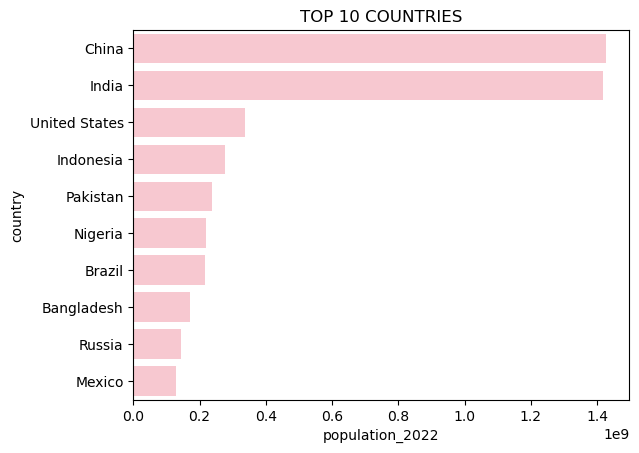

In [46]:
query=""" select country , 2022_population
          from population_data_staging
          order by 2022_population desc
          limit 10"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["country","population_2022"])
print(df)

sns.barplot(data=df , x="population_2022",y="country",color="pink")
plt.title("TOP 10 COUNTRIES")
plt.show()

# Population growth by continent

       continent population_2022  average_growth
0           Asia      4721383274        1.009384
1         Africa      1426730932        1.021244
2         Europe       743147538        1.002256
3  North America       600296136        1.004175
4  South America       436816608        1.007957
5        Oceania        45038554        1.007383


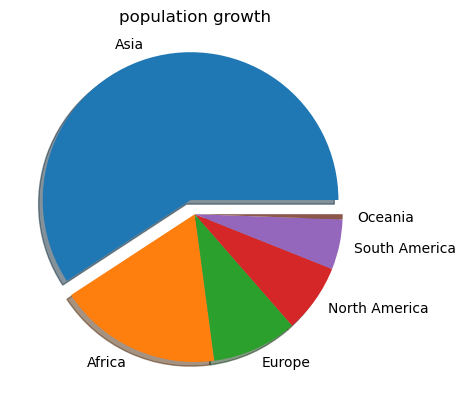

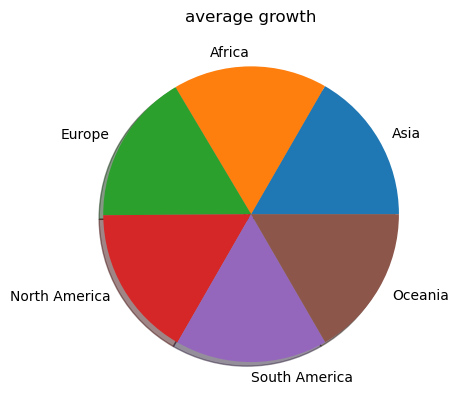

In [83]:
query=""" select continent , sum(2022_population) , avg(growth_rate)
          from population_data_staging
          group by continent
          order by sum(2022_population) desc
         """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["continent","population_2022","average_growth"])
print(df)
ex=[0.1,0,0,0,0,0]
plt.pie(x=df["population_2022"],labels=df["continent"],shadow=True , explode=ex)
ex=[0.1,0,0,0,0,0]
plt.title("population growth")
plt.show()




plt.pie(x=df["average_growth"],labels=df["continent"],shadow=True)   # showing nearly same trend
plt.title("average growth")
plt.show()

# Population density vs area size

        country  area   density
0         Macau    30  23172.30
1        Monaco     2  18234.50
2     Singapore   710   8416.46
3     Hong Kong  1104   6783.39
4     Gibraltar     6   5441.50
5       Bahrain   765   1924.49
6      Maldives   300   1745.96
7         Malta   316   1687.61
8  Sint Maarten    34   1299.26
9       Bermuda    54   1188.59


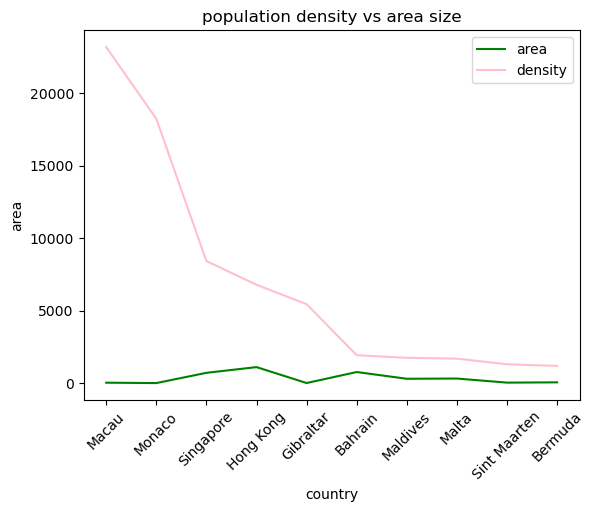

In [59]:
query=""" select country,area,density
          from population_data_staging
          order by density desc
          limit 10
         """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["country","area","density"])
print(df)

sns.lineplot(data=df, x="country",y="area",color="green",label="area")
sns.lineplot(data=df, x="country",y="density",color="pink",label="density")
plt.legend()
plt.title("population density vs area size")
plt.xticks(rotation=45)
plt.show()

# Smallest countries by population density

            country  density
0         Greenland   0.0261
1  Falkland Islands   0.3105
2    Western Sahara   2.1654
3          Mongolia   2.1727
4           Namibia   3.1092
5         Australia   3.4032
6           Iceland   3.6204
7     French Guiana   3.6459
8            Guyana   3.7621
9          Suriname   3.7727


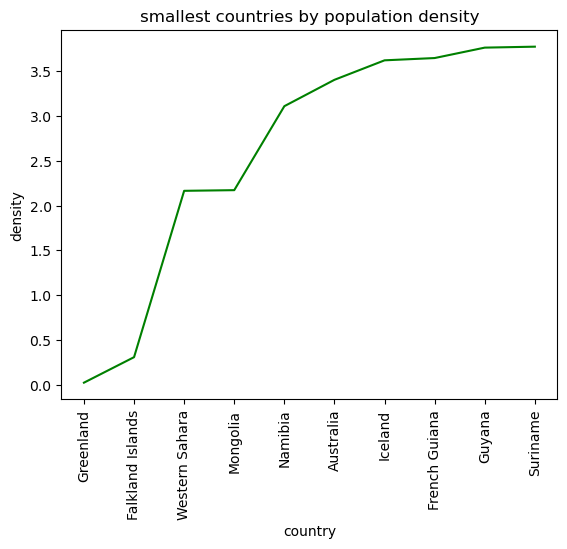

In [84]:
query=""" select country,density
          from population_data_staging
          order by density asc
          limit 10
         """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["country","density"])
print(df)

sns.lineplot(data=df,x="country",y="density",color="green")
plt.xticks(rotation=90)
plt.title("smallest countries by population density")
plt.show()

# Fastest growing countries

In [18]:
 query=""" select country,growth_rate
         from population_data_staging
          order by growth_rate desc
          limit 10  """ 
      

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["country","growth rate"])
print(df)

    country  growth rate
0   Moldova       1.0691
1    Poland       1.0404
2     Niger       1.0378
3     Syria       1.0376
4  Slovakia       1.0359
5  DR Congo       1.0325
6   Mayotte       1.0319
7      Chad       1.0316
8    Angola       1.0315
9      Mali       1.0314


# Population of countries in 1970 and 2022

          country  population 1970  population 2022
0           China        822534450       1425887337
1           India        557501301       1417173173
2   United States        200328340        338289857
3       Indonesia        115228394        275501339
4        Pakistan         59290872        235824862
5         Nigeria         55569264        218541212
6          Brazil         96369875        215313498
7      Bangladesh         67541860        171186372
8          Russia        130093010        144713314
9          Mexico         50289306        127504125
10          Japan        105416839        123951692
11       Ethiopia         28308246        123379924
12    Philippines         37435586        115559009
13          Egypt         34781986        110990103
14       DR Congo         20151733         99010212
15        Vietnam         41928849         98186856
16           Iran         28449705         88550570
17         Turkey         35540990         85341241
18        Ge

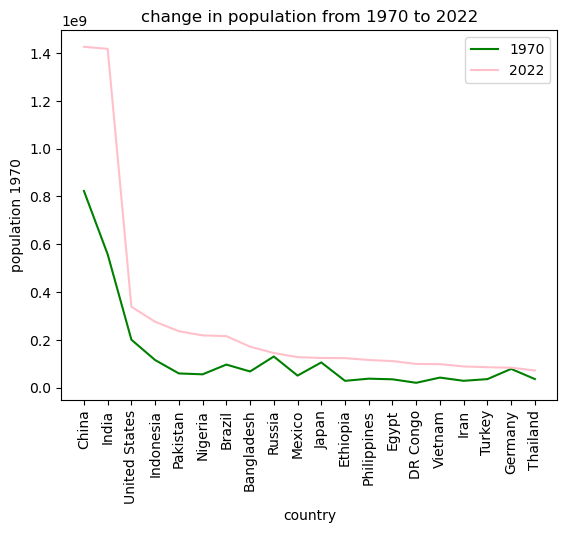

In [76]:
query=""" select country,1970_population , 2022_population
         from population_data_staging
          order by 2022_population desc
          limit 20
           """ 
      

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["country","population 1970" ,"population 2022"])
print(df)

sns.lineplot(data=df,x="country",y="population 1970",color="green",label="1970")
sns.lineplot(data=df,x="country",y="population 2022",color="pink",label="2022")
plt.xticks(rotation=90)
plt.title("change in population from 1970 to 2022")
plt.show()

# Percent change in population from 1970 to 2022 for each country

In [19]:
query=""" select country,((2022_population-1970_population)/1970_population)*100 population_change
         from population_data_staging
          order by population_change desc
           """ 
      

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["country","population_percent_change"])
print(df)

                      country population_percent_change
0        United Arab Emirates                 3067.2713
1                       Qatar                 2183.8662
2                     Mayotte                  821.6319
3    Turks and Caicos Islands                  706.7608
4                    Djibouti                  676.3241
..                        ...                       ...
229                   Georgia                  -21.9989
230                    Latvia                  -22.8064
231              Vatican City                  -32.1809
232                Montserrat                  -61.4980
233                      Niue                  -62.7001

[234 rows x 2 columns]


# Countries contributing the most to global population

In [29]:
query=""" select country,world_population_percentage
         from population_data_staging
          order by world_population_percentage desc
          limit 10
           """ 
      

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["country","world population percentage"])
print(df)

         country  world population percentage
0          China                        17.88
1          India                        17.77
2  United States                         4.24
3      Indonesia                         3.45
4       Pakistan                         2.96
5        Nigeria                         2.74
6         Brazil                         2.70
7     Bangladesh                         2.15
8         Russia                         1.81
9         Mexico                         1.60


# Fastest growing countries by decade

In [36]:
query=""" select country , ((2022_population-2010_population)/2010_population)*100 growth

           from population_data_staging
           order by growth desc
           limit 10;
           """ 
      

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["country"," growth_2010s"])
print(df)

                    country  growth_2010s
0                    Jordan       62.8257
1                      Oman       58.7937
2                     Niger       57.4285
3                     Qatar       57.2872
4                   Mayotte       53.9767
5  Turks and Caicos Islands       53.7476
6         Equatorial Guinea       53.0262
7                    Angola       52.3228
8                  DR Congo       49.1314
9                      Chad       49.0014


# Slowest growing countries by decade

In [37]:
query=""" select country , ((2022_population-2010_population)/2010_population)*100 growth

           from population_data_staging
           order by growth 
           limit 10;
           """ 
      

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["country"," growth_2010s"])
print(df)

                  country  growth_2010s
0        Marshall Islands      -22.1787
1          American Samoa      -19.2820
2  Bosnia and Herzegovina      -15.1548
3            Vatican City      -14.4295
4                 Ukraine      -13.0930
5            Saint Martin      -12.8010
6             Puerto Rico      -12.5208
7               Lithuania      -12.3913
8       Wallis and Futuna      -11.9464
9                  Latvia      -11.9379


# Continent wise population density

       continent continent density
0           Asia          146.9090
1         Africa           47.0589
2         Europe           32.2961
3  North America           24.7604
4  South America           24.4943
5        Oceania            5.2893


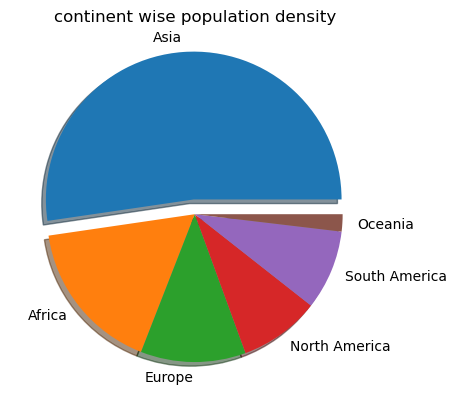

In [66]:
query=""" select continent , sum(2022_population)/sum(area) continent_density

           from population_data_staging
           group by continent
           order by continent_density desc
           """ 
      

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data , columns=["continent","continent density"])
print(df)

ex=[0.1,0,0,0,0,0]
plt.pie(x=df["continent density"],labels=df["continent"],shadow=True,explode=ex)

plt.title("continent wise population density")
plt.show()